<a href="https://colab.research.google.com/github/Or-Gindes/MachineLearningAssignment3/blob/master/Assignment3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning - Assignment No. 3

### Part 2 – Aim: Practice the usage of CNN (Convolutional Neural Network). 


In this part you will use at least two pretrained CNNs to identify the type of a flower that appears in an image. You will need to choose your pretrained models and use Transfer Learning to associate flower images into their corresponding categories.

We would like the model to classify the image into its category (the dandelions category in this example). The model should be probabilistic and returns the probability of a flower belonging to each of the categories.

In [1]:
# Get /flowers/102 files
import os
from urllib.request import urlretrieve
seed=123

dataset = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
# segs = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz"
labels = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
urlretrieve(dataset, dataset.rsplit('/', 1)[-1])
# urlretrieve(segs, segs.rsplit('/', 1)[-1])
urlretrieve(labels, labels.rsplit('/', 1)[-1])

('imagelabels.mat', <http.client.HTTPMessage at 0x7fef957bb850>)

Number of unique classes: 102


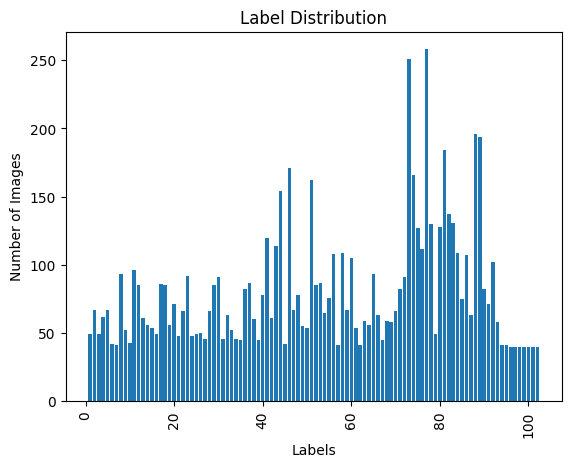

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

mat = scipy.io.loadmat(labels.rsplit('/', 1)[-1])
y = pd.Series(mat['labels'][0])
unique_labels = y.unique()
print(f"Number of unique classes: {len(unique_labels)}")

plt.bar(unique_labels, y.value_counts())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Label Distribution')
plt.xticks(rotation='vertical')
plt.show()

CNN off-the-shelf


*   Take pre-trained CNN (YOLOV5, VGG19)
*   Removed the last fully-connected layer
*   Take the rest of the CNN as a fixed feature extractor
*   Train on https://www.robots.ox.ac.uk/~vgg/data/flowers/102/ 





In [10]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications import vgg19
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # load_img, img_to_array, array_to_img

Extract the images and prepare to read them using ImageDataGenerator - 

In [5]:
import tarfile

tgz_file = dataset.rsplit('/', 1)[-1]

with tarfile.open(tgz_file, 'r:gz') as file:
    # Extract all files to the specified directory
    file.extractall('.')

### TODOS:
1. Getting it to work (VGG19 + flow_from_dataframe) -
    1. test current setup with GPU
    2. try to fix one-hot encoding
    3. try transfer learning with less layers (e.g. layer 4)

2. Hyperparameter Tuning
3. Write code blocks in functions and apply to YOLOv5 also
4. Provide an accuracy graph and the Cross-Entropy graph for train/validation/test as a function of the number of epochs for all models.

In [ ]:
# This code block currently fails due to RAM issues

# # Load images to array (data generator "flow")
# image_path = "./jpg"
# image_file_names = os.listdir(image_path)
# image_file_names.sort()
# image_array_list = []
# for image_file_name in image_file_names:
#     tf_image = keras.preprocessing.image.load_img(
#         path=f"{image_path}/{image_file_name}",
#         grayscale=False,
#         target_size=(224,224,),
#     )
#     img_array = keras.preprocessing.image.img_to_array(tf_image)
#     process_img = vgg19.preprocess_input(img_array)
#     image_array_list.append(process_img)

# # Prepare train/validation/test sets (0.5/0.25/0.25)
# X_train, X_val_test, y_train, y_val_test = train_test_split(
#     image_array_list,
#     one_hot_labels,
#     test_size=0.5,
#     random_state=seed,
#     shuffle=True,
#     stratify=y,
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_val_test,
#     y_val_test,
#     test_size=0.5,
#     random_state=seed,
#     shuffle=True,
#     stratify=y_val_test,
# )

# # Prepare data generators
# train_data_gen = ImageDataGenerator()
# valid_data_gen = ImageDataGenerator()
# test_data_gen = ImageDataGenerator()

# # Setting up the generators
# training_generator = train_data_gen.flow(
#     x=np.array(X_train), y=y_train, batch_size=32
# )
# validation_generator = valid_data_gen.flow(
#     x=np.array(X_val), y=y_val, batch_size=32
# )
# test_generator = test_data_gen.flow(
#     x=np.array(X_test), y=y_test, batch_size=32
# )

In [3]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoding for labels
oh_encoder = OneHotEncoder()

image_labels = scipy.io.loadmat(labels.rsplit('/', 1)[-1])["labels"][0]
image_labels_2d = image_labels.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
one_hot_labels = encoder.fit_transform(image_labels_2d)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
import pandas as pd

# Prepare dataframe for flow_from_dataframe
data_dir = os.path.join(os.getcwd(), 'jpg')
df = pd.DataFrame({"filename": os.listdir(data_dir),  "class": y.astype(str)})
df.head()

# This might be needed for the onehotencoded labels?
# df['class'] = df['class'].apply(lambda row: row.tolist())

,filename,class
0,image_06966.jpg,77
1,image_07188.jpg,77
2,image_03578.jpg,77
3,image_01030.jpg,77
4,image_06418.jpg,77


Split the data to Training (50%), Validation (25%) and Test (25%) sets

In [15]:
from sklearn.model_selection import train_test_split

# Preprocessing - define image size required by the model
# Define preprocessing function as the models preprocess_input function

def get_data_generators(df, img_size, preprocessing_function, batch_size=32):
    train_df, val_test_df = train_test_split(df, stratify=df['class'], test_size=0.5, 
                                             random_state=seed, shuffle=True)
    val_df, test_df = train_test_split(val_test_df, 
                                       stratify=val_test_df['class'], 
                                       test_size=0.5, random_state=seed, shuffle=True)

    # TODO: Need to check if resizing helps
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)#, resize=1/255)
    valid_data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)#, resize=1/255)
    test_data_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)#, resize=1/255)
    print("Training:")
    train_generator = train_data_gen.flow_from_dataframe(
        train_df,
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed
    )

    print("Validation:")
    validation_generator = valid_data_gen.flow_from_dataframe(
        val_df,
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed
    )

    print("Test:")
    test_generator = test_data_gen.flow_from_dataframe(
        test_df,
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed
    )

    return train_generator, validation_generator, test_generator

From keras guide to transfer learning -
1.   Take layers from a previously trained model.
2.  Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

### VGG19 - 

Preprocessing for this model is accomplished with the preprocess_input function which converts the input images from RGB to BGR and zero-centers each color channel with respect to the ImageNet dataset, without scaling the image. The images are read with target_size 224x224 which is the input side of the model

In [16]:
train_generator, validation_generator, test_generator = get_data_generators(df, img_size=(224, 224), preprocessing_function=vgg19.preprocess_input)

Training:
Found 4094 validated image filenames belonging to 102 classes.
Validation:
Found 2047 validated image filenames belonging to 102 classes.
Test:
Found 2048 validated image filenames belonging to 102 classes.


load the model (without its final top predictive layers) and take a look at its structure

In [17]:
# Load the VGG19 model with its imagenet pretrained weights
# but without the final 3 fully connected layers at the top of the network
base_model = vgg19.VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Set base_model weights to not be trainable (required for transfer learning)
base_model.trainable = False

# Create new "top model" to meld with the base_model
# Only top model will be trained in transfer learning
inputs = keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)  # Add a Flatten layer here
x = Dense(256, activation='relu')(x)  # Add a Dense layer for additional non-linearity
x = Dropout(0.2)(x)
outputs = Dense(len(unique_labels), activation='softmax')(x)

model = Model(inputs, outputs)

# Train the model on the flowers images
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', mode="max")

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=50, callbacks=[early_stopping], 
                    validation_data=validation_generator, verbose=1)

Epoch 1/50
128/128 [==============================] - 3030s 24s/step - loss: 6.5043 - accuracy: 0.0259 - val_loss: 4.6147 - val_accuracy: 0.0313
Epoch 2/50
 92/128 [====================>.........] - ETA: 9:25 - loss: 4.5510 - accuracy: 0.0418

In [ ]:
"""
These cells are different ways to setup the "top-model"
not really needed if the top part will work but can try different "top-model"
architectures
"""


# Transfer learning - Freeze the weights of the base_model 
base_model.trainable = False

# Define a new top model
n_classes = len(y.unique())

top_model = Sequential()
top_model.add(keras.layers.GlobalAveragePooling2D())
top_model.add(Dense(n_classes, activation='softmax'))

# Combine the base_model with new top model
# bot_model = Model(input=base_model.input, output=base_model.get_layer('block4_pool').output)
model = Sequential()
model.add(base_model)
model.add(top_model)

# Train the model on the flowers images
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=100, callbacks=[early_stopping], 
                    validation_data=validation_generator, verbose=1)

Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 9.2068 - accuracy: 0.0129 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

In [ ]:
# Transfer learning - Freeze the weights of the base_model 
base_model.trainable = False

# Define a new top model
n_classes = len(y.unique())

top_model = Sequential()
top_model.add(Flatten())
top_model.add(Dropout(rate=0.2))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dropout(rate=0.2))
top_model.add(Dense(n_classes, activation='softmax'))

# Combine the base_model with new top model
model = Sequential()
model.add(base_model)
model.add(top_model)

# Train the model on the flowers images
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=100, callbacks=[early_stopping], 
                    validation_data=validation_generator)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)